<a href="https://colab.research.google.com/github/slarkdev/AnomaliesDetection/blob/main/anomaly_detection_cnn_dt2_lesly_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
import os
import datetime
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
import random

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.layers import Input

# Fijar semilla aleatoria
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def guardar_proyecto(model, y_test, anomalías, history, matriz, nombre_base="modelo_anomalias"):

    # 🕒 Crear carpeta con timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    carpeta = f"/content/drive/MyDrive/3w-dataset-train-test/entrenamientos-2/{nombre_base}_{timestamp}"
    os.makedirs(carpeta, exist_ok=True)

    # 1. Guardar el modelo
    modelo_path = os.path.join(carpeta, f"{nombre_base}.h5")
    model.save(modelo_path)

    # 2. Guardar métricas
    reporte = classification_report(y_test, anomalías)
    acc = accuracy_score(y_test, anomalías)
    f1 = f1_score(y_test, anomalías)
    recall = recall_score(y_test, anomalías)
    precision = precision_score(y_test,anomalías)
    auc = roc_auc_score(y_test, anomalías)

    with open(os.path.join(carpeta, "reporte_metricas.txt"), "w") as f:
        f.write("REPORTE DE CLASIFICACIÓN\n")
        f.write(reporte)
        f.write("\n\nMétricas adicionales:\n")
        f.write(f"Accuracy: {acc:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1-score: {f1:.4f}\n")
        f.write(f"AUC-ROC: {auc:.4f}\n")

    # 3. Guardar historial de entrenamiento
    pd.DataFrame(history.history).to_csv(os.path.join(carpeta, "historial_entrenamiento.csv"), index=False)

    total_anomalias = int(np.sum(y_test))  # Cantidad total de anomalías
    anomalías_predichas = int(np.sum(anomalías.astype(int)))  # Convertir booleanos a enteros

    # Crear gráfico de barras
    plt.bar(["Real Anomalies", "Anomalies Detected"], [total_anomalias, anomalías_predichas], color=['red', 'blue'])

    # Personalizar gráfico
    plt.ylabel("Number of Anomalies")
    plt.title("Comparison of Real vs. Predicted Anomalies")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(carpeta, "grafico_comparison_real_vs_anomalies.png"))
    plt.close()


    # grafico 4 matriz de confusion
    sns.heatmap(matriz, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Normal", "Anomalous"], yticklabels=["Normal", "Anomalous"])
    plt.xlabel("Prediction")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(carpeta, "grafico_confusion_matriz.png"))
    plt.close()


    print(f"✅ Todo guardado exitosamente en la carpeta: {carpeta}")


In [4]:
def crearGraficos(TimeSeries):


  plt.figure(figsize=(8, 3))
  plt.plot(TimeSeries['P-TPT'], label='P-TPT')
  plt.legend();

  plt.figure(figsize=(8, 3))
  plt.plot(TimeSeries['T-TPT'], label='T-TPT')
  plt.legend();

  plt.figure(figsize=(8, 3))
  plt.plot(TimeSeries['P-MON-CKP'], label='P-MON-CKP')
  plt.legend();

  plt.figure(figsize=(8, 3))
  plt.plot(TimeSeries['T-JUS-CKP'], label='T-JUS-CKP')
  plt.legend();

  plt.figure(figsize=(8, 3))
  plt.plot(TimeSeries['P-JUS-CKGL'], label='P-JUS-CKGL')
  plt.legend();

  plt.figure(figsize=(8, 3))
  plt.plot(TimeSeries['class'], label='class')
  plt.legend();


In [5]:
# Calcular métricas
def obtenerMetricas(y_test, anomalías):
  accuracy = accuracy_score(y_test, anomalías)
  f1 = f1_score(y_test, anomalías)
  recall = recall_score(y_test, anomalías)
  precision = precision_score(y_test,anomalías)
  roc_auc = roc_auc_score(y_test, anomalías)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-score: {f1:.4f}")
  print(f"AUC-ROC: {roc_auc:.4f}")

In [6]:
def anteriores1000(timestamp):
  df_normal_anteriores = df_normal[df_normal.index < timestamp]  # Filtra solo los anteriores
  df_normal_anteriores = df_normal_anteriores.sort_values("timestamp").tail(1000)  # Toma los últimos 10,000 antes del evento anómalo

  return df_normal_anteriores

In [7]:
def posteriores1000(timestamp):
  df_normal_posteriores = df_normal[df_normal.index > timestamp]  # Filtra solo los posteriores
  df_normal_posteriores = df_normal_posteriores.sort_values("timestamp").head(1000)  # Toma los últimos 10,000 antes del evento anómalo

  return df_normal_posteriores


# ** Configuracion y Aplicacion del Modelo **

In [8]:
#Especificar las rutas de los archivos en Google Drive
ruta_dataset0 = "/content/drive/MyDrive/3w-dataset-train-test/dataset-train.csv"

ruta_csv1 = "/content/drive/MyDrive/3w-dataset-train-test/dataset-test-01.csv"
ruta_csv2 = "/content/drive/MyDrive/3w-dataset-train-test/dataset-test-02.csv"
ruta_csv3 = "/content/drive/MyDrive/3w-dataset-train-test/dataset-test-06.csv"

df0 = pd.read_csv(ruta_dataset0, parse_dates=['timestamp'], index_col='timestamp')
# Leer los CSV en DataFrames
df1 = pd.read_csv(ruta_csv1, parse_dates=['timestamp'], index_col='timestamp')
df2 = pd.read_csv(ruta_csv2, parse_dates=['timestamp'], index_col='timestamp')
df3 = pd.read_csv(ruta_csv3, parse_dates=['timestamp'], index_col='timestamp')

df_unido = pd.concat([df1, df2, df3], ignore_index=False)

# Mostrar las primeras filas del DataFrame combinado
df_unido

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,class
timestamp,,,,,,
2014-01-26 20:00:50,0.995514,0.032099,0.990271,0.000000,1.000000,0.0
2014-01-26 20:00:51,0.995529,0.032034,0.990280,0.000000,0.999811,0.0
2014-01-26 20:00:52,0.995544,0.031968,0.990288,0.000000,0.999615,0.0
2014-01-26 20:00:53,0.995554,0.031902,0.990297,0.000000,0.999426,0.0
2014-01-26 20:00:54,0.995569,0.031837,0.990305,0.000000,0.999230,0.0
...,...,...,...,...,...,...
2014-03-25 20:23:20,0.999782,0.117603,0.999960,0.000061,0.873050,1.0
2014-03-25 20:23:21,0.999837,0.117452,0.999970,0.000094,0.872939,1.0
2014-03-25 20:23:22,0.999891,0.117151,0.999980,0.000123,0.872827,1.0


In [9]:
df0 = df0[~df0.index.duplicated(keep="first")]

df0

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,class
timestamp,,,,,,
2013-12-11 23:00:15,0.998766,0.668012,0.967624,1.000000,0.591835,0.0
2013-12-11 23:00:16,0.998757,0.667947,0.967581,1.000000,0.591822,0.0
2013-12-11 23:00:17,0.998749,0.667860,0.967538,1.000000,0.591810,0.0
2013-12-11 23:00:18,0.998741,0.667795,0.967495,1.000000,0.591798,0.0
2013-12-11 23:00:19,0.998731,0.667730,0.967452,1.000000,0.591785,0.0
...,...,...,...,...,...,...
2017-02-11 10:18:43,0.068794,0.593010,0.114767,0.032128,0.016705,0.0
2017-02-11 10:18:44,0.068811,0.593075,0.112556,0.031791,0.016705,0.0
2017-02-11 10:18:45,0.068827,0.593162,0.110345,0.031454,0.016705,0.0


# **Para la Anomalia 2 debemos hacer los siguiente con el dataset: **

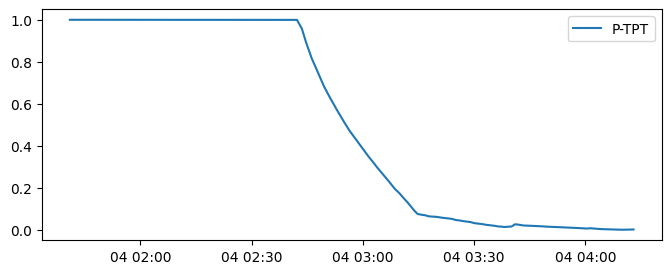

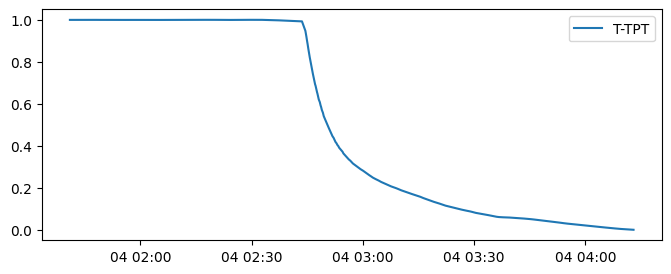

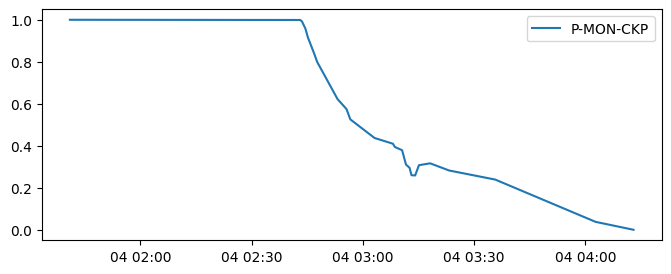

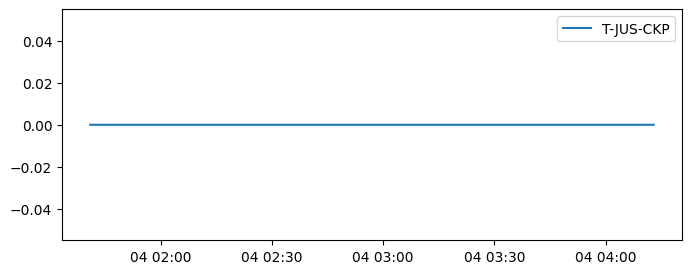

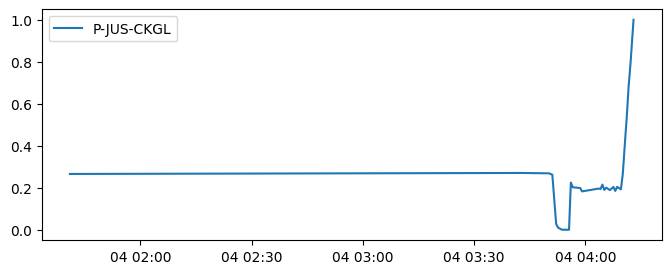

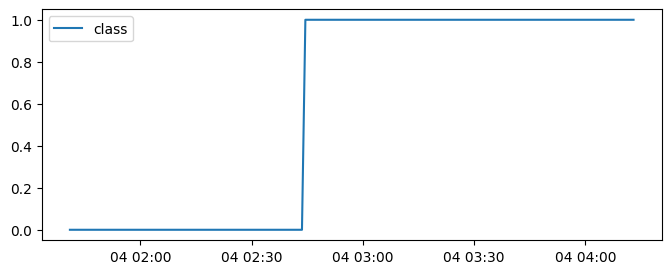

In [10]:
crearGraficos(df2)

In [11]:
df_anomalo = df2.sort_values("timestamp")
df_normal = df0.sort_values("timestamp")

primer_timestamp_anomalo = df_anomalo.index.min()
ultimo_timestamp_anomalo = df_anomalo.index.max()

print(primer_timestamp_anomalo)
print(ultimo_timestamp_anomalo)
#--

df_normal_posteriores = df_normal[df_normal.index > ultimo_timestamp_anomalo]  # Filtra solo los posteriores
df_normal_posteriores = df_normal_posteriores.sort_values("timestamp").head(10000)  # Toma los últimos 10,000 antes del evento anómalo

df_normal_posteriores
#--

df_anomalo = df_anomalo.sort_values("timestamp")
df_normal_posteriores = df_normal_posteriores.sort_values("timestamp")

df_balanced = pd.concat([df_anomalo, df_normal_posteriores], ignore_index=False)
df_balanced.sort_values("timestamp")

#--
df_balanced = df_balanced.resample("1s").asfreq()  # Ajusta la frecuencia a cada segundo (modifica a '1min' si es por minutos)
df_balanced

#--
df_balanced["P-TPT"] = df_balanced["P-TPT"].bfill()#.interpolate(method="linear")  # Interpolamos
df_balanced["T-TPT"] = df_balanced["T-TPT"].bfill() #.interpolate(method="linear")  # Interpolamos
df_balanced["P-MON-CKP"] = df_balanced["P-MON-CKP"].bfill() #.interpolate(method="linear")  # Interpolamos
df_balanced["T-JUS-CKP"] = df_balanced["T-JUS-CKP"].bfill() #.interpolate(method="linear")  # Interpolamos
df_balanced["P-JUS-CKGL"] = df_balanced["P-JUS-CKGL"].bfill() #.interpolate(method="linear")  # Interpolamos
df_balanced["class"] = df_balanced["class"].bfill()

dataset_aux = df_balanced.head(70000)

dataset_2 = dataset_aux #pd.concat([dataset_aux, df2], ignore_index=False)
dataset_2 =  dataset_2.sort_values("timestamp")

#--
dataset_2 = dataset_2[~dataset_2.index.duplicated(keep="first")]
#--
dataset_2 = dataset_2.resample("1s").asfreq()  # Ajusta la frecuencia a cada segundo (modifica a '1min' si es por minutos)
print(dataset_2["class"].value_counts())
dataset_2


2013-11-04 01:41:01
2013-11-04 04:13:01
class
0.0    64635
1.0     5365
Name: count, dtype: int64


,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,class
timestamp,,,,,,
2013-11-04 01:41:01,1.000000,0.999478,1.000000,0.0,0.265832,0.0
2013-11-04 01:41:02,1.000000,0.999477,1.000000,0.0,0.265833,0.0
2013-11-04 01:41:03,1.000000,0.999476,1.000000,0.0,0.265833,0.0
2013-11-04 01:41:04,1.000000,0.999475,0.999999,0.0,0.265834,0.0
2013-11-04 01:41:05,1.000000,0.999475,0.999999,0.0,0.265835,0.0
...,...,...,...,...,...,...
2013-11-04 21:07:36,0.998766,0.668012,0.967624,1.0,0.591835,0.0
2013-11-04 21:07:37,0.998766,0.668012,0.967624,1.0,0.591835,0.0
2013-11-04 21:07:38,0.998766,0.668012,0.967624,1.0,0.591835,0.0


In [12]:
# Guardamos el dataset
ruta_guardado = "/content/drive/MyDrive/3w-dataset-train-test/dataset-interpolado-Anomalia2.csv"

# 🚀 Guardar el DataFrame en Google Drive
dataset_2.to_csv(ruta_guardado, index=True)

# ✅ Confirmación de guardado
print(f"Archivo guardado en: {ruta_guardado}")

Archivo guardado en: /content/drive/MyDrive/3w-dataset-train-test/dataset-interpolado-Anomalia2.csv


Fin de preprocesamiento de dataset

In [13]:
# Definir las columnas de entrada y salida:
input_columns = ['P-TPT',	'T-TPT','P-MON-CKP', 'T-JUS-CKP','P-JUS-CKGL',]
output_columns = ['class']

In [14]:
# Supongamos que tu DataFrame está ordenado cronológicamente y se llama df

# Tamaños de cada conjunto
tam_train = 49000

# Total de datos
total = len(dataset_2)

# Índices para corte
idx_train_start = total - tam_train

# Cortes
train = dataset_2.iloc[idx_train_start:]
test = dataset_2.iloc[:idx_train_start]

print(test['class'].value_counts())
test

class
0.0    15635
1.0     5365
Name: count, dtype: int64


,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,class
timestamp,,,,,,
2013-11-04 01:41:01,1.000000,0.999478,1.000000,0.0,0.265832,0.0
2013-11-04 01:41:02,1.000000,0.999477,1.000000,0.0,0.265833,0.0
2013-11-04 01:41:03,1.000000,0.999476,1.000000,0.0,0.265833,0.0
2013-11-04 01:41:04,1.000000,0.999475,0.999999,0.0,0.265834,0.0
2013-11-04 01:41:05,1.000000,0.999475,0.999999,0.0,0.265835,0.0
...,...,...,...,...,...,...
2013-11-04 07:30:56,0.998766,0.668012,0.967624,1.0,0.591835,0.0
2013-11-04 07:30:57,0.998766,0.668012,0.967624,1.0,0.591835,0.0
2013-11-04 07:30:58,0.998766,0.668012,0.967624,1.0,0.591835,0.0


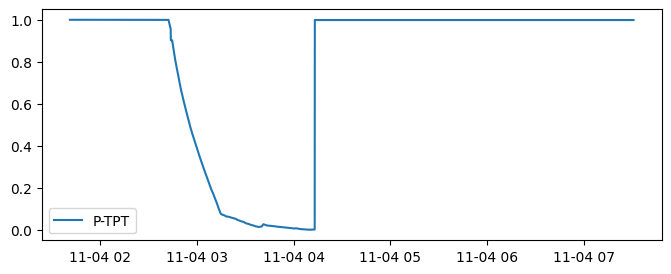

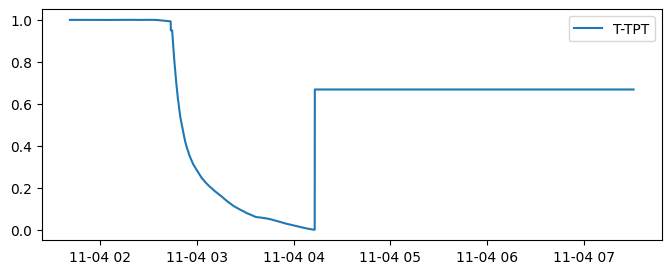

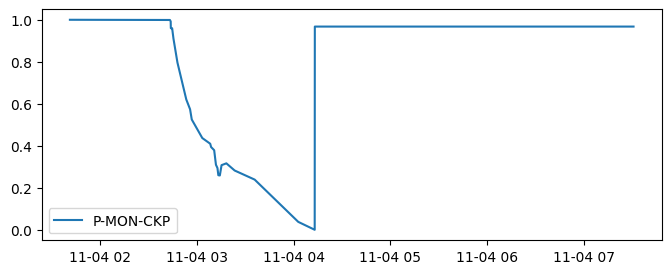

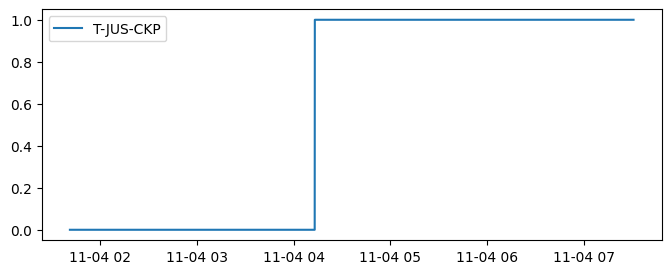

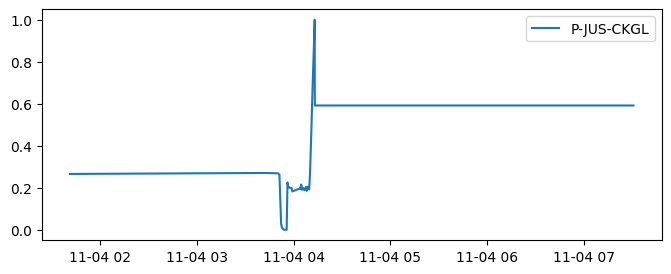

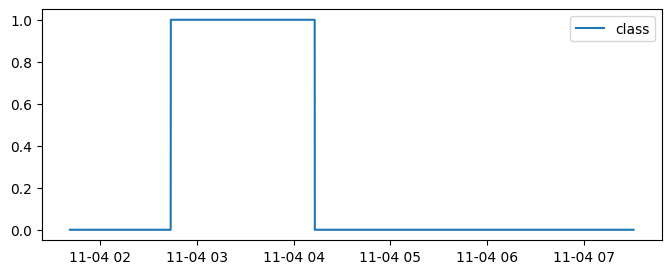

In [15]:
crearGraficos(test)

In [16]:
train = train.sort_values("timestamp")
test = test.sort_values("timestamp")

print(train['class'].value_counts())
print(test['class'].value_counts())

class
0.0    49000
Name: count, dtype: int64
class
0.0    15635
1.0     5365
Name: count, dtype: int64


In [17]:
# Definir una función para crear secuencias de longitud sequence_length
def create_sequences(data, sequence_length):
 X = []
 y = []
 for i in range(len(data) - sequence_length):
    X.append(data.iloc[i:i+sequence_length][input_columns].values)
    y.append(data.iloc[i+sequence_length][output_columns].values)
 return np.array(X), np.array(y)

In [18]:
VentanaTiempo = 400 # segun tipo de anomalia, Anomalia 01: 400, anomalia 02: 5-20 minutos, anomalia 06: 15 minutos

# Crear secuencias de entrenamiento
X_train, y_train = create_sequences(train, VentanaTiempo)
X_test, y_test = create_sequences(test, VentanaTiempo)

print(X_train.shape)
print(X_test.shape)

(48600, 400, 5)
(20600, 400, 5)


In [95]:
# Definir entrada explícita
from tensorflow.keras.layers import Input

columnas_serie_temporal = 5

input_layer = Input(shape=(VentanaTiempo, columnas_serie_temporal))
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Crear el modelo funcional
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])


In [96]:
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.int32)

X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.int32)

In [97]:
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=64,
    class_weight = {0: 1.0, 1: 50.0}
)

Epoch 1/40
760/760 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 1.0000 - loss: 0.0517 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/40
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.7907e-05 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/40
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 5.9678e-06 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/40
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 2.7058e-06 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/40
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.5529e-06 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/40
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 8.6079e-07 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/40
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 5.6500e-07 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8/40
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accur

# CALCULAMOS LAS ANOMALIAS IDENTIFICADAS POR EL MODELO Y LAS COMPARAMOS CON LAS REALES

In [98]:
for layer in model.layers:
    print(layer.name)


input_layer_5
conv1d_10
batch_normalization_10
max_pooling1d_10
conv1d_11
batch_normalization_11
max_pooling1d_11
flatten_5
dense_10
dropout_5
dense_11


In [99]:
from tensorflow.keras.models import Model

# Definir un modelo auxiliar para extraer activaciones
layer_name = 'dense_10'  # Nombre de la capa oculta antes de la salida final
activation_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Obtener activaciones para datos normales
activaciones_train = activation_model.predict(X_train)


1519/1519 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [100]:
from scipy.spatial.distance import euclidean, mahalanobis

# Calcular el centroide (media de activaciones normales)
centroide = np.mean(activaciones_train, axis=0)

# Obtener activaciones de datos de prueba
activaciones_test = activation_model.predict(X_test)

# Calcular la matriz de covarianza y su inversa
cov_matrix = np.cov(activaciones_train.T)
cov_inv = np.linalg.inv(cov_matrix + np.eye(cov_matrix.shape[0]) * 1e-5)  # Regularización

# Calcular distancias Mahalanobis
distancias_mah = [mahalanobis(a, centroide, cov_inv) for a in activaciones_test]
distancias_mah = np.array(distancias_mah)

# Calcular distancias Euclidianas
distancias = [euclidean(activacion, centroide) for activacion in activaciones_test]
distancias = np.array(distancias)


644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Accuracy: 0.9359
Precision: 0.8635
Recall: 0.8952
F1-score: 0.8791
AUC-ROC: 0.9227
Matriz de confusión con umbral ajustado:
[[14476   759]
 [  562  4803]]
Reporte de clasificación con umbral ajustado:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     15235
           1       0.86      0.90      0.88      5365

    accuracy                           0.94     20600
   macro avg       0.91      0.92      0.92     20600
weighted avg       0.94      0.94      0.94     20600



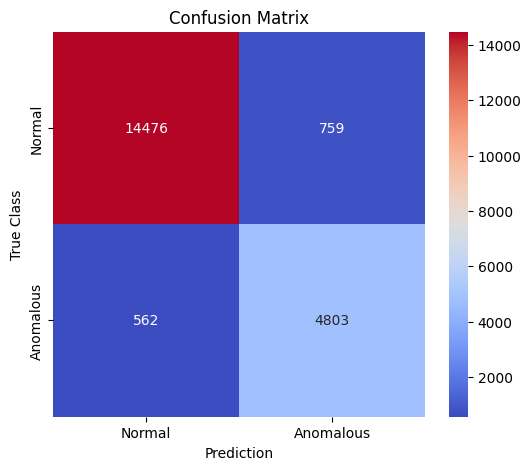

In [101]:

# Definir umbral con percentil 90 de las distancias normales Aqui decides si usar distancia euclidiana o mahalanobis
umbral = np.percentile(distancias_mah, 73)

# Detectar anomalías (si la distancia es mayor al umbral, se considera anómala)
y_pred = (distancias_mah > umbral).astype(int)  # 1 = anómalo, 0 = normal

from sklearn.metrics import classification_report, confusion_matrix

obtenerMetricas(y_test,y_pred)
#anomalías = y_pred
print("Matriz de confusión con umbral ajustado:")
matriz = confusion_matrix(y_test, y_pred)
print(matriz)

print("Reporte de clasificación con umbral ajustado:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6,5))
sns.heatmap(matriz, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Normal", "Anomalous"], yticklabels=["Normal", "Anomalous"])
plt.xlabel("Prediction")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

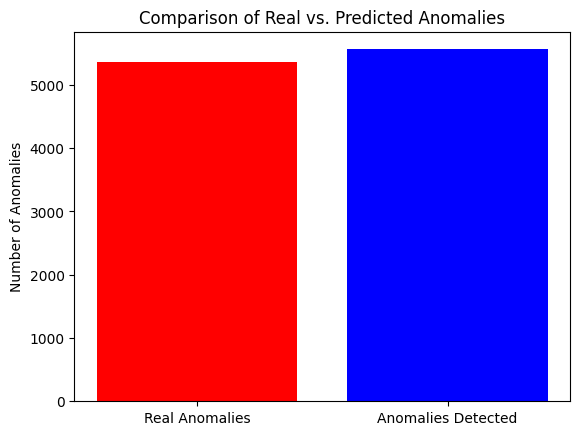

In [102]:
import matplotlib.pyplot as plt

total_anomalias = int(np.sum(y_test))  # Cantidad total de anomalías
anomalías_predichas = int(np.sum(y_pred.astype(int)))  # Convertir booleanos a enteros

# Crear gráfico de barras
plt.bar(["Real Anomalies", "Anomalies Detected"], [total_anomalias, anomalías_predichas], color=['red', 'blue'])

# Personalizar gráfico
plt.ylabel("Number of Anomalies")
plt.title("Comparison of Real vs. Predicted Anomalies")
plt.show()


In [103]:
guardar_proyecto(model, y_test, y_pred, history, matriz, nombre_base='cnn_ocl_dt2_ws_400_bs_64_e_40_acc_9359')


/tmp/ipython-input-3-2597150070.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


✅ Todo guardado exitosamente en la carpeta: /content/drive/MyDrive/3w-dataset-train-test/entrenamientos-2/cnn_ocl_dt2_ws_400_bs_64_e_40_acc_9359_20250625_223344
